# Lab Assignment One: Exploring Table Data

### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng


### 1. Business Understanding 

This data is intended to be used as a predictive tool whether a patient is likely to have a stroke based on certain medical features. It can also be used to detect trends in which features contribute to whether a person has a stroke or not. 

According to the Center for Disease Control and Prevention (CDC) (https://www.cdc.gov/stroke/facts.htm), more than 795,000 people in the United States have a stroke with 610,000 being first time strokes. Not only does this impact the lives of a variety of populations, but it also creates a huge impact on the cost of the American Healthcare system, with stroke-related costs being about 56.5 billion dollars in 2018 and 2019. 

There are many factors/risks associated with having a stroke, as indicated by https://www.strokeinfo.org/stroke-risk-factors/, such as high blood pressure, obesity (which can be measured with body mass index - BMI), family history, high cholesterol, and an age above 65. Lifestyle habits such as smoking and poor diet can also increase this risk. Typically, it is recommended to visit a medical professional when a person has multiple risk factors for a stroke. There is an abundance of data that is obtained from electronic health care records, most of which are features which are usually not relevant or useful. Machine Learning could play a beneficial role in facilitating predicitive tools that could measure the risk of having a stroke with the most important features (in this dataset there are 11 features with 5110 occurances). This offers a cheaper alternative and would be of interest to the medical professionals, specifically to primary care physicians (PCP) who deal with the routine care of patients from all ages and backgrounds.

As such, the aims of exploring this dataset would be to detect which features have the highest risk associated with having a stroke. The data was collected from Kaggle, however, after extensive research on where the meta-data came from, it can only be assumed that it was collected and trunacted from the electronic health records from McKinsey & Company (we believe it came from this paper specifically: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9264165).

### Measures of Success

Dealing with measures of success when it comes to the medical field can be difficult and varies based on whether you have balanced or imbalanced data. In this scenario, doctors and patients would like a high success rate. In the case of imbalanced data, it is often taken care of through sensitivity or recall (true positive rate), where the number of true positives (people who had a stroke and were predicted to have a stroke) is divided by the number of true positives plus the number of false negatives (people who had a stroke but were classified as not having a stroke). From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/ "It is the likelihood that the patient has a high risk of stroke is correctly predicted." Combined with recall, precision is the number of true positives divided by the number of true positives plus the number of false positives (those who did not have a stroke but were predicted to). It essentially indicates how many of those who had a stroke actually belong to that class. Lastly, another measure of success, regardless of balanced or imbalanced data, is through specificity (true negative rate), which measures the proportion of individuals who are classified to not have a stroke to the total number of actual nonstroke cases, i.e. the probability that a patient who does not have a high risk of stroke will have a negative result. 

All of these techniques can be used to measure the successful outcomes of ML models with a particular dataset. The overarching goal would be to have true positives and true negatives, rather than false negatives and false positives, to mitigate unecessary medical costs. 

Dataset source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download 

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
# Use the 'missingno' package which is an external package to detect any missing values
import missingno as mn
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as piopio
import seaborn as sns
import umap
import umap.plot
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
piopio.renderers.default='notebook'
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

# load the stroke dataset

df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df.drop(columns = ["id"], inplace = True)
df.head() 

gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1

In [3]:
#info about dataset types
df.describe()

age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4909.000000  5110.000000  
mean     28.893237     0.048728  
std       7.854067     0.215320  
min      10.300000     0.000000  
25%      23.500000     0.000000  
50%      28.100000     0.000000  
75%      33.100000     0.000000  
max      97.600000     1.000000

In [4]:
#Continious Data and categorical data
attribute_cols = list(df.columns)
categorical_cols = [column for column in attribute_cols if len(df[column].unique())<=5]
continous_cols = [column for column in attribute_cols if column not in categorical_cols]

print(f"Continous Data Columns: {','.join(continous_cols)}")
print(f"Categorical Data Columns: {','.join(categorical_cols)}")

Continous Data Columns: age,avg_glucose_level,bmi
Categorical Data Columns: gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke


### 2. Data Understanding
#### 2.1. Load the dataset and appropriately define data types. 

In [5]:
df.info()
print('========================================')
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
av

In [6]:
# Finding unique values in each arribute
unique_values = {column:df[column].unique() for column in df.columns}

for column, values in unique_values.items():
    print(f"Unique values in '{column}': {values}")

Unique values in 'gender': ['Male' 'Female' 'Other']
Unique values in 'age': [6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01
 3.50e+01 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01
 4.00e+00 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01
 3.30e+01 2.40e+01 3.40e+01 3.60e+01 6.40e-01 4.10e+01 8.80e-01 5.00e+00
 2.60e+01 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01
 2.80e+01 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00
 1.00e+00 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 7.20e-01 1.88e+00
 1.24e+00 8.00e-01 4.00e-01 8.00e-02 1.48e+00 5

#### Observation:
- The unique values within the object columns clearly guide us in identifying the types of categorical attributes and determining the most appropriate encoding method to use. 
- Additionally, a detailed analysis of the numerical data aids in achieving a more comprehensive understanding of data quality

### Answers to the Questions in 2.1

Remove the id variable.  It doesn't have any analytical value

- **What data type should be used to represent each data attribute?**
  1.	gender: Nominal categorical. one-hot encoding is recommended to transform this into numeric formats, representing each category (Male/Female/Other)
  2.	age: this is a numeric variable representing a continuous quantity. The current Datype ‘float64’ is appropriate as age can be fractional to represent months and days along with years in precise calculations).
  3.	hypertension: Binary categorical with values [0,1]. The current Dtype ‘int64’ is appropriate as it represents binary data straightforwardly.
  4.	heart_disease:  Similar to hypertension is correctly represented as ‘int64’.
  5.	every_married: It’s a binary categorical (Yes/No) that should be represneted as binary numeric data (1 for “Yes”, 0 for "No”) by using label encoding.
  6.	work_type: This is a nominal categorical variable with 4 categories ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
  7.	Residence_type: This is a nominal categorical variable with two categories 'Urban' and 'Rural', also recommending using one-hot encoding.
  8.	avg_glucose_level: This is a continuous numerical variable representing a ratio. The float64 data type is appropriate.
  9.	bmi: This is also a continuous numerical variable representing a ratio. It is appropriately represented as float64. It contains missing values (NaN).
  10.	smoking_status: Similar to work_type, nominal categorical including 4 categories ['formerly smoked', 'never smoked', 'smokes', 'Unknown'], recommend using one-hot encoding.
  11.	stroke: This is a binary outcome variable (target variable) with values [1, 0], representing the occurrence of a stroke. The int64 data type is suitable for this binary variable.
  
  
  

- **Discuss the attributes collected in the dataset. For datasets with a large number of attributes, only discuss a subset of relevant attributes.**
 - **Stroke** is the target variable which is the label that we will study. The other attributes are the variables we will learn their relationship with the label to find the pattern under the dataset. We will also study correlations between each other attributes to have a better insight into our dataset.
  - For preprocessing and preparing the dataset for machine learning models, all the categorical variables will be encoded to present with numerical values.
    - For nominal data where no ordinal relationship exists such as gender, work_type, Residence_type, and smoking_status, one-hot encoding is typically used.
    - For binary data or ordinal data such as 'ever_married' label encoding can be appropriate.




#### 2.2 Verify data quality:
- Explain any missing values or duplicate data. 
- Visualize entries that are missing/complete for different attributes.
- Are those mistakes? 
- Why do these quality issues exist in the data? 
- How do you deal with these problems? 
- Give justifications for your methods (elimination or imputation).  


In [7]:
# Check for duplicate rows across the entire
duplicates = df.duplicated()
print("Duplicate rows across all columns:")
print(df[duplicates])

Duplicate rows across all columns:
Empty DataFrame
Columns: [gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke]
Index: []


#### Observation:
- Our data is unique at the row level. There is no duplicated row.
- The output is an "Empty DataFrame" with a list of columns but no rows under the "Index:[]"line after checking for duplicate rows across all columns, meaning our DataFrame does not contain any rows that are completely duplicated across all columns. In other words, there are no two rows in the DataFrame that are exactly the same in terms of all their columns values.

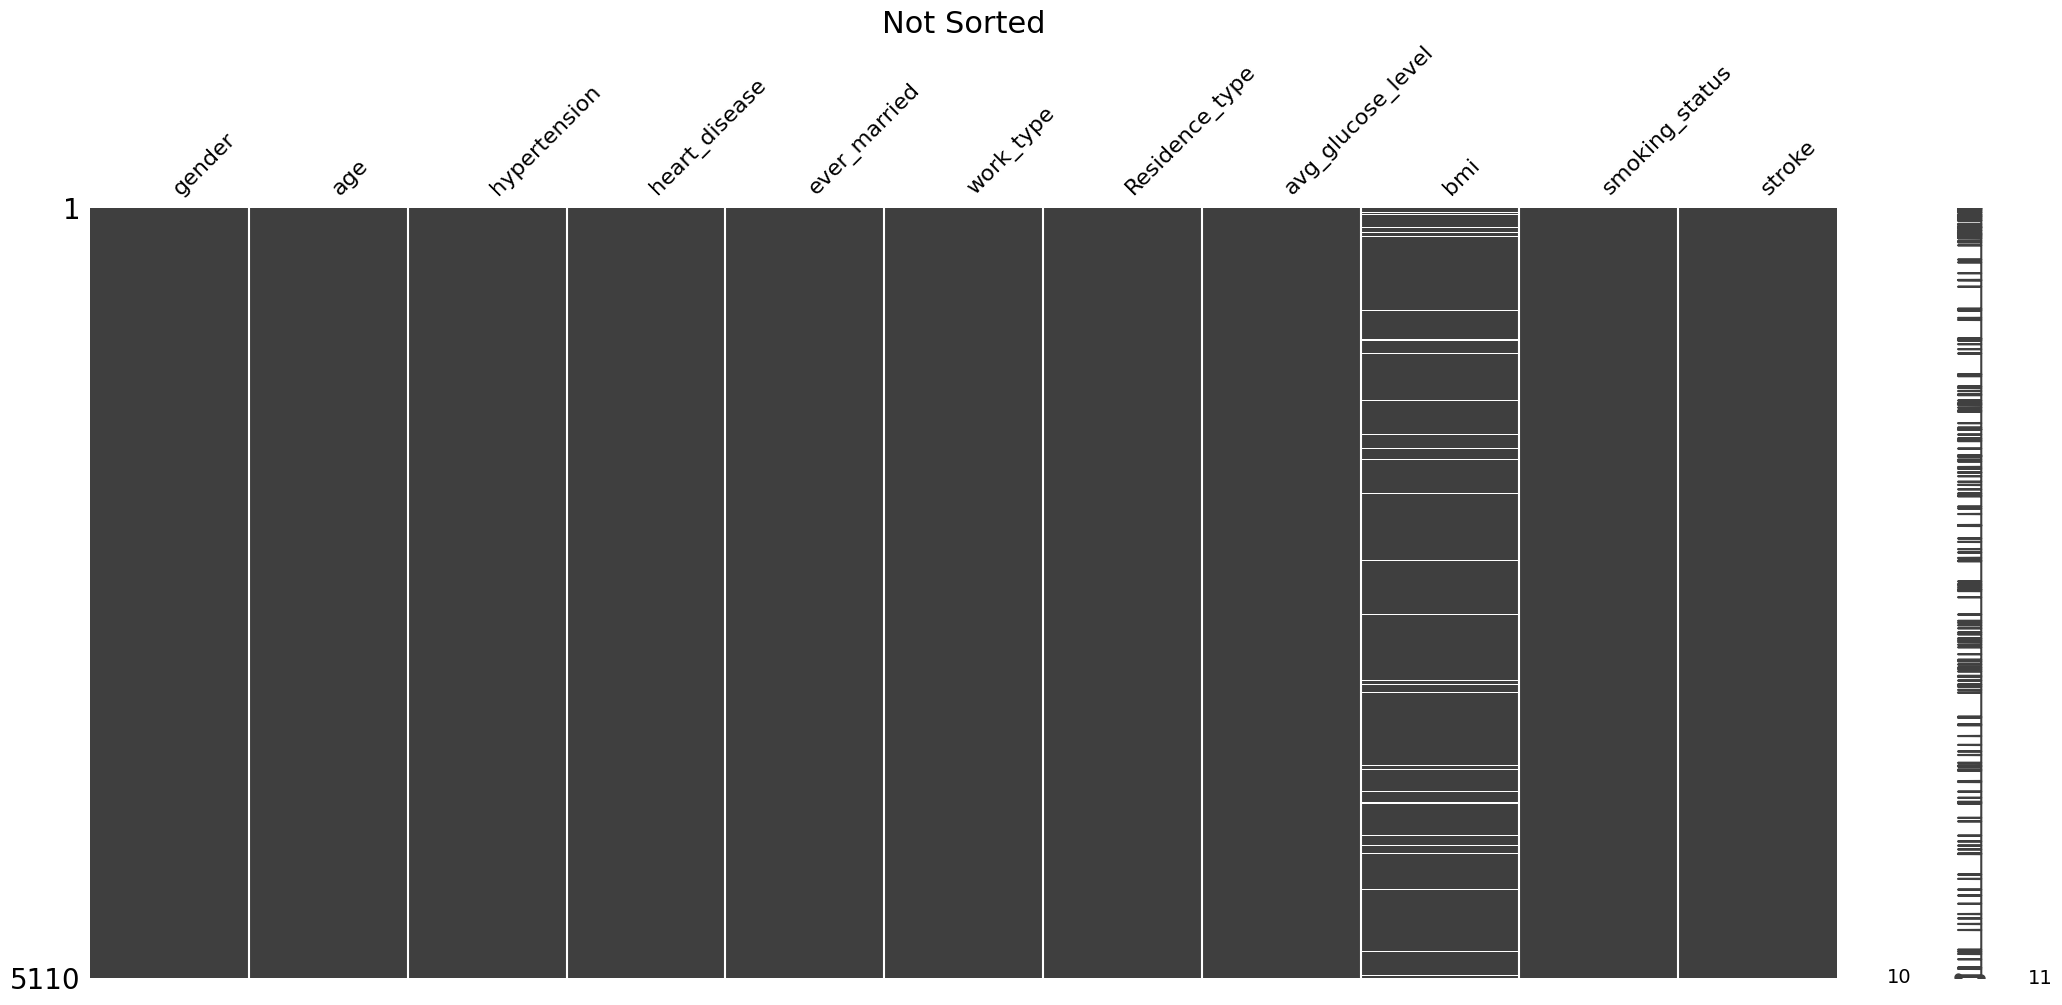

<Figure size 640x480 with 0 Axes>

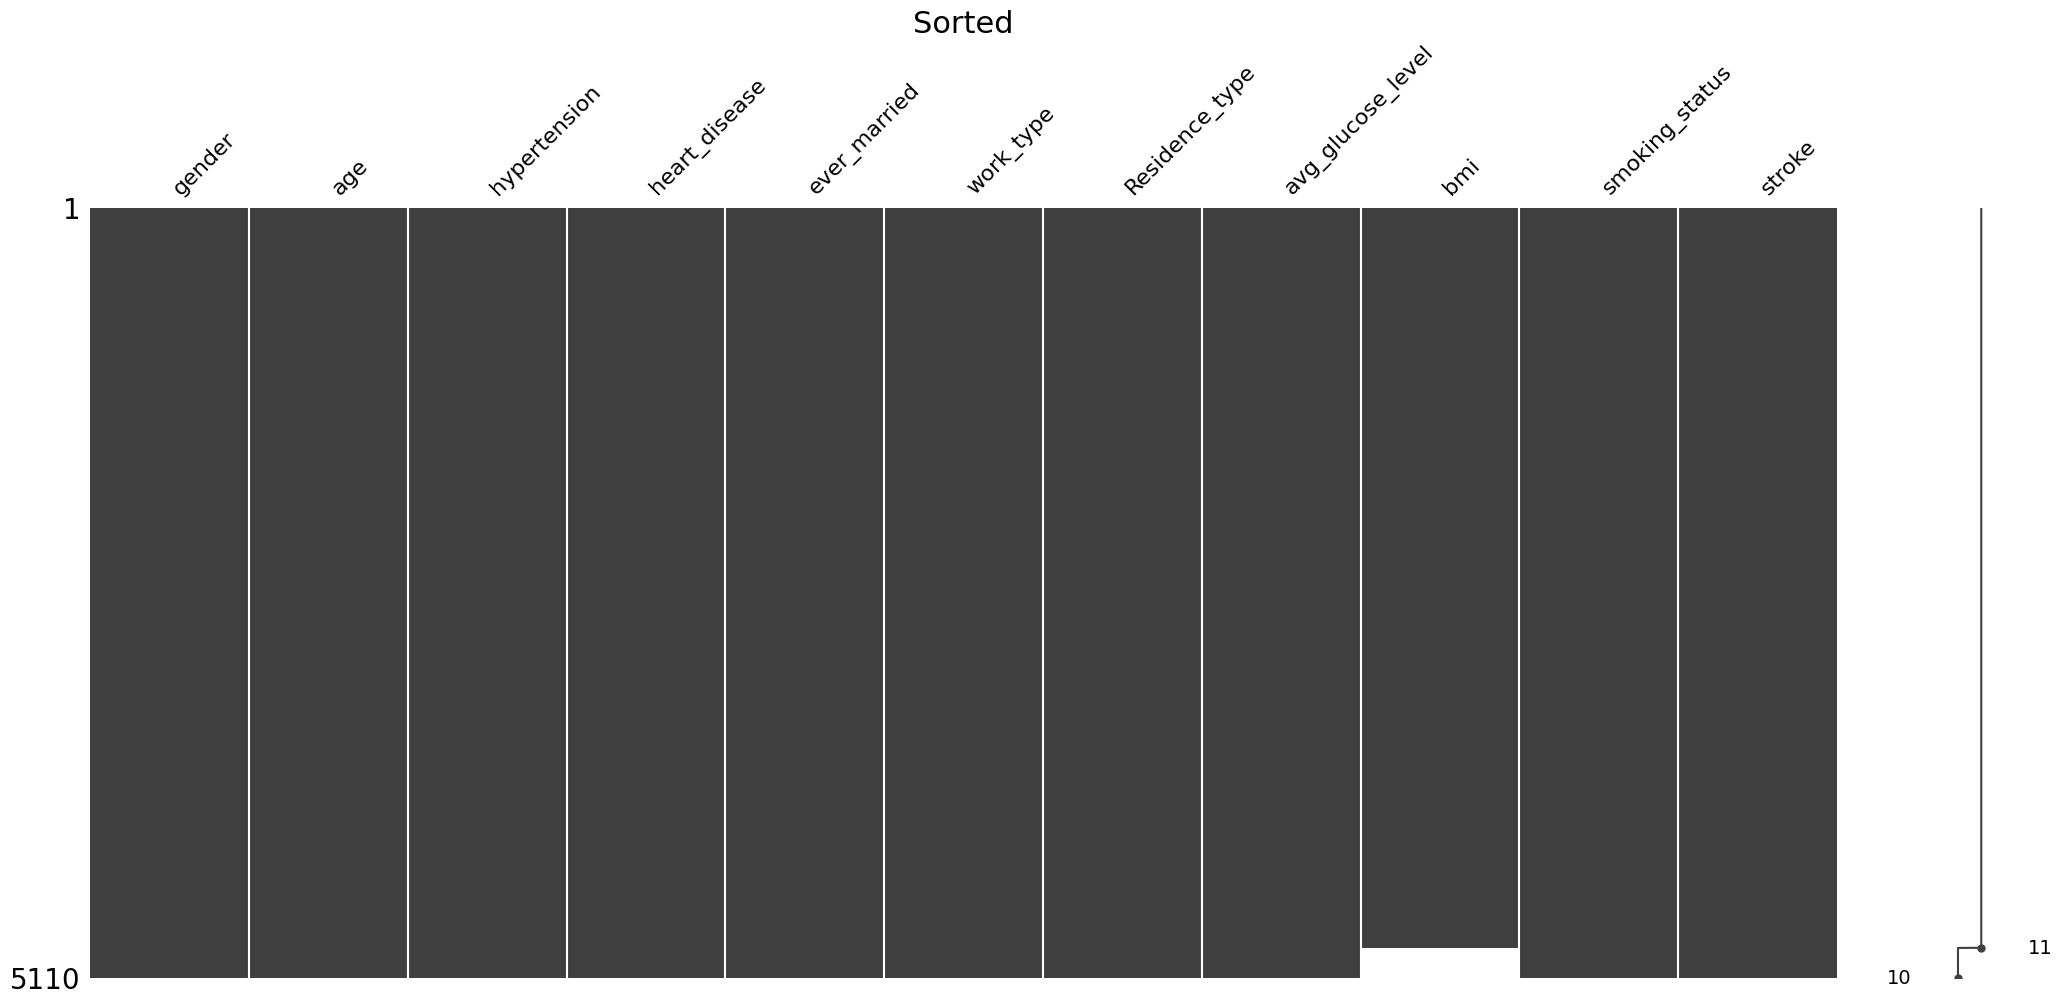

In [8]:
# Visualize entries that are missing/complete for different attributes.

mn.matrix(df)
plt.title('Not Sorted', fontsize=22)

plt.figure()
mn.matrix(df.sort_values(by=["bmi"]))
plt.title("Sorted", fontsize=22)
plt.show()

#### Observation from the missingness visualization:
- Only BMI variable has missing values. Values in the other attributes are complete.
- Missing values in bmi are randomly distributed.
- BMI variable seems to be missing about 10% of the values.

#### Imputation Techniques

We will try two methods of imputation on the bmi varibale, and compare imputation distributions:
 - Split-Impute-Combine (SIC)
 - K-Nearest Neighbor Imputation (KNN)

#### Split-Impute-Combine

In [9]:
# Impute some missing values, grouped by ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
# then use this grouping to fill the data set in each group, then transform back

df_grouped = df.groupby(by=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# This will now also apply to 'bmi'
func = lambda grp: grp.fillna(grp.mean()) # within groups, fill using median (define function to do this)

numeric_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level','bmi', 'stroke'] # only transform numeric columns
df_imputed_sic = df_grouped[numeric_columns].transform(func) # apply impute and transform the data back

# Extra step: fill any object columns that could not be transformed
col_deleted = list( set(df.columns) - set(df_imputed_sic.columns)) # in case the median operation deleted columns
df_imputed_sic[col_deleted] = df[col_deleted]


# Now check if 'bmi' has been imputed correctly
print(df_imputed_sic['bmi'].isnull().sum()) # This should ideally show 0, indicating all missing values have been imputed


# drop any rows that still had missing values after grouped imputation
df_imputed_sic.dropna(inplace=True)

# 5. Rearrange the columns
df_imputed_sic = df_imputed_sic[['gender','age','hypertension', 'heart_disease', 'work_type', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']]
df_imputed_sic.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   work_type          5110 non-null   object 
 5   ever_married       5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


#### Nearest Neighbor Imputation with Scikit-learn
 - Fill in the BMI varibale by selecting the 3 nearest data points.

In [10]:
from sklearn.impute import KNNImputer
import copy

# get object for imputation
knn_obj = KNNImputer(n_neighbors=3)

features_to_use = ['age', 'hypertension', 'heart_disease', 'bmi', 'avg_glucose_level', 'stroke']

# create a numpy matrix from pandas numeric values to impute
temp = df[features_to_use].to_numpy()

# use sklearn imputation object
knn_obj.fit(temp) # fit the object to learn about the dataset's structure
temp_imputed = knn_obj.transform(temp) # transform the data by imputing missing values based on the 3 nearest neighbors
##could have also done:
# temp_imputed = knn_obj.fit_transform(temp)

# Make a deep copy to make sure the original dataset will not be manipulated
df_imputed = copy.deepcopy(df) # not just an alias
df_imputed[features_to_use] = temp_imputed
# df_imputed.dropna(inplace=True)

df_imputed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   float64
 3   heart_disease      5110 non-null   float64
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   float64
dtypes: float64(6), object(5)
memory usage: 439.3+ KB


In [11]:
# properties of the imputer after fitting
print(knn_obj.n_features_in_)

6


#### Comparing Imputation Distrubutions

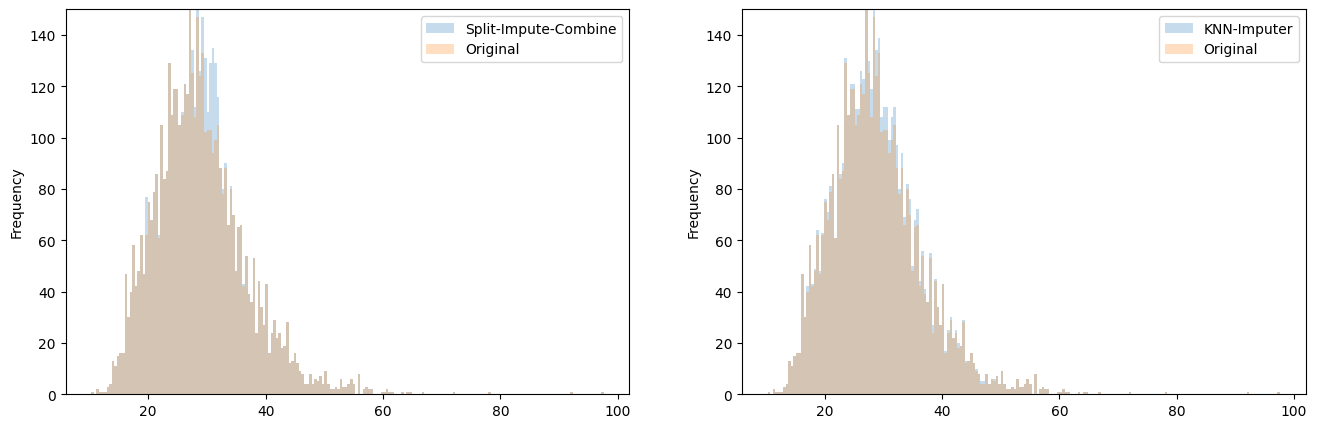

In [12]:
f = plt.figure(figsize=(16,5))

bin_num = 200
plt.subplot(1,2,1)
df_imputed_sic.bmi.plot(kind='hist', alpha=0.25, 
                        label="Split-Impute-Combine",
                        bins=bin_num)

df.bmi.plot(kind='hist', alpha=0.25, 
                        label="Original",
                        bins=bin_num)
plt.legend()
plt.ylim([0, 150])

plt.subplot(1,2,2)
df_imputed.bmi.plot(kind='hist', alpha=0.25, 
                        label="KNN-Imputer",
                        bins=bin_num)

df.bmi.plot(kind='hist', alpha=0.25, 
                        label="Original",
                        bins=bin_num)
plt.legend()
plt.ylim([0, 150])

plt.show()

#### Observation from the results after two imputation methods:
- The values imputed using the KNN-Imputation method are more balanced compared to those from the Split-Impute-Combine method.
- Given that the missing values in BMI are randomly distributed, we will opt for the KNN-Imputation method to address the missing BMI values.

#### Encoding categorical variables back to numerical values:
- Use one-hot coding for gender, work_type, Residence_type, and smoking_status
- Use label encoding for ever_married

In [13]:
# Label encoding for binary data
df_imputed['ever_married'] = df_imputed['ever_married'].map({'Yes': 1, 'No': 0})

# One-hot encoding for nominal data
df_imputed = pd.get_dummies(df_imputed, columns=['gender', 'work_type', 'Residence_type', 'smoking_status'], drop_first=False)

print(df_imputed.head())

    age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0  67.0           0.0            1.0             1             228.69   
1  61.0           0.0            0.0             1             202.21   
2  80.0           0.0            1.0             1             105.92   
3  49.0           0.0            0.0             1             171.23   
4  79.0           1.0            0.0             1             174.12   

         bmi  stroke  gender_Female  gender_Male  gender_Other  ...  \
0  36.600000     1.0          False         True         False  ...   
1  30.866667     1.0           True        False         False  ...   
2  32.500000     1.0          False         True         False  ...   
3  34.400000     1.0           True        False         False  ...   
4  24.000000     1.0           True        False         False  ...   

   work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                   False               True                 

In [14]:
print(df_imputed.columns)

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'stroke', 'gender_Female', 'gender_Male',
       'gender_Other', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Rural', 'Residence_type_Urban',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


#### Observations on Encoded Features:
- This structure confirms that the encoding has been executed as anticipated, transforming categorical variables into numerical formats that align with our domain knowledge and expectations. 
- The creation of distinct columns for each category within variables such as gender, work type, residence type, and smoking status ensures a precise and interpretable representation of our data for further analysis.

### Answers to Questions in 2.1

#### Missing Values or Duplicate Data
- By oberserving the dataset information and checking whole entries using missingness visualization, the dataset has missing values specifically in the BMI attribute. The missingness is randomly distributed.
- Our data is unique at the row level and there is no duplicated row by checking the duplicated rows across all the columns.

#### Visualizing Missing/Complete Entries
- By checking whole entries using missingness visualization techniques, the dataset has missing values specifically in the BMI attribute. The missingness is randomly distributed.
- There are no missing values in the other attributes.

#### Are Those Mistakes? 
The missingness is random from the missingness visualization technical analyzing, which suggests there's no systematic error causing these missing values.Missing values aren't necessarily "mistakes" but are rather common in real-world data.

#### Why Do These Quality Issues Exist?
- Random missing values can occur due to
 - Data Entry Errors: Manual data entry is prone to errors.
 - Collection Process: Incomplete collection processes or issues during data transmission can result in missing data.
 - Data Management: Issues in data storage or handling can lead to both missing values and duplicates.

#### Dealing with These Problems
 - **Missing Values:**
  - **Imputation:** Since the missing values in BMI are randomly distributed and constitute about 10% of the data, imputation is a justified method. We experimented with two appropriate imputation methods of Split-impute-Combine (SIC) and Split-Input-Combine (SIC) and compared the results visually to pick one that was more optimized.
  -	**Elimination**: Removing entries with missing values is another option but less ideal here due to the loss of valuable data.
  
- **Duplicate Data:**
 - Duplicates should be identified and removed unless there's a specific justification for retaining them, such as repeated measurements that are valid within the context of the study.

#### Justifications for Methods
 - **Imputation Justification:**
  - Since the missing values in BMI are randomly distributed and constitute about 10% of the data, imputation is a justified method. KNN-Imputation is chosen due to its balanced outcome compared to the Split-Impute-Combine method. KNN can handle the randomness in missingness by imputing values based on similar cases.
  
- **Elimination:**
 - Not recommended for this dataset due to the manageable level of missing values and the potential loss of valuable information, especially when a balanced imputation method like KNN is available.


### 3. Data Visualization

### 3.1 Data Exploration

In [15]:
#stroke samples
fig = px.pie(df,names='stroke')
fig.update_layout(title='<b>Percentage of Stroke Samples<b>')
fig.show()

As evident above, we are experiencing a highly imbalanced dataset (95.1% of the data has no stroke, while only 4.87% have stroke), which would have to be dealt with in prediction models, either with upscaling or oversampling. 

Let's look at the distribution of the continuous data: bmi, avg_glucose_level, and age. 

<Axes: xlabel='gender', ylabel='avg_glucose_level'>

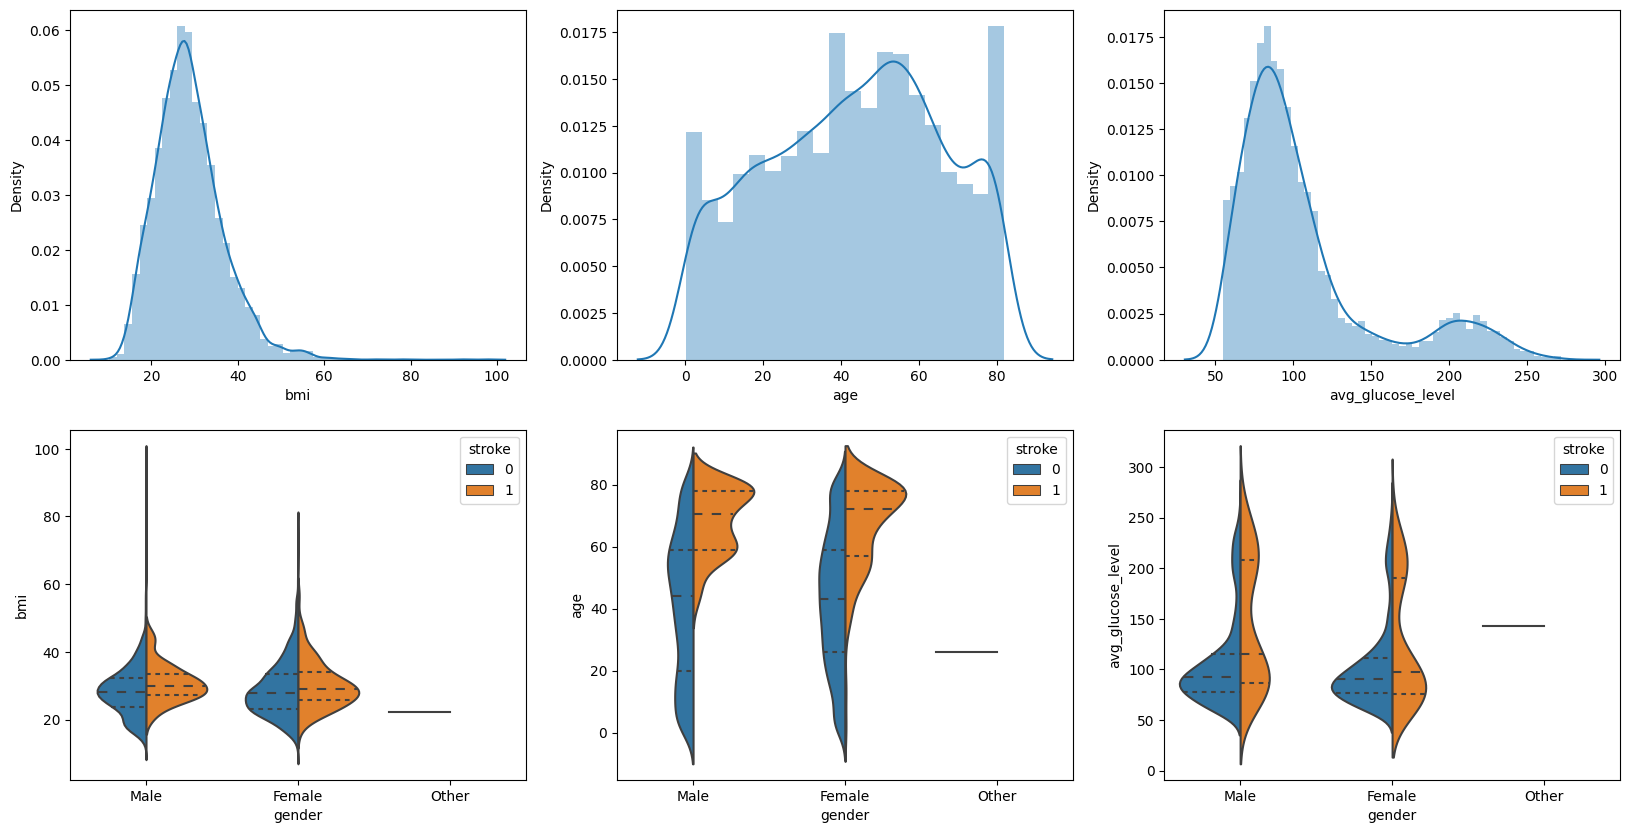

In [16]:
#Distribution of continuous data
plt.subplots(2,3,figsize=(20,10))

plt.subplot(2,3,1)
sns.distplot(df.bmi)
plt.subplot(2,3,2)
sns.distplot(df.age)
plt.subplot(2,3,3)
sns.distplot(df.avg_glucose_level)
plt.subplot(2,3,4)
sns.violinplot(x="gender", y="bmi", hue="stroke", data=df, split=True, s=3, inner='quart')

plt.subplot(2,3,5)
sns.violinplot(x="gender",y="age",hue="stroke", data=df, split=True, s=3, inner='quart')

plt.subplot(2,3,6)
sns.violinplot(x="gender",y="avg_glucose_level",hue="stroke", data=df, split=True, s=3, inner='quart')

Looking at the distribution plot for bmi, there is a normal distribution, which is also evident in the violin plot below. We plotted the violin plot and split the data between those who had a stroke, and those who didn't. There are a lot of outliers in the bmi, as shown in the violin plot, and there is no significant difference between male and females with regard to having a stroke versus not having a stroke. 

For age, we do see that male and females share similar distribution for those who did not have a stroke, as shown in the violin plot. The overall distribution of age appears to be multimodal, and there is a bimodal distribution for older (>40) males that have had a stroke. For women, it appears there is a slighly less promeninent bimodal distribution that have had a stroke.

Lastly, the avg_glucose_level has a bimodal distribution. Taking a deeper look into the violin plot, both males and females have similiar distribution for stroke and no stroke. It appears that the stroke is more distributed to account for the higher glucose levels that appear in the data. 


In the data there is only one 'Other' category, which is present here. Since there is no significance between the three continous data and the stroke, we recommend to remove this entry as it is not signficant. 

Lets take a look at the continous variables in a scatterplot:

Now lets take a closer look at the age feature by splitting it into different labels:

In [17]:
df['age_range'] = pd.cut(df['age'],
                             [0,13,19,30,55,1e6],
                             labels=['child', 'teen', 'young_adult','adult','elder'])
df.age_range.describe()

count      5110
unique        5
top       adult
freq       1844
Name: age_range, dtype: object

In [18]:
grouped = df.groupby(['age_range', 'stroke']).size().unstack()

total_counts = grouped.sum(axis=1)

percent_with_stroke = (grouped[1] / total_counts) * 100
percent_no_stroke = (grouped[0] / total_counts) * 100

print("Percentage with stroke")
for index, value in percent_with_stroke.items():
    print(f'{index}: {value:.2f}%')

print("Percentage with no stroke")
for index, value in percent_no_stroke.items():
    print(f'{index}: {value:.2f}%')

Percentage with stroke
child: 0.16%
teen: 0.31%
young_adult: 0.00%
adult: 2.01%
elder: 12.38%
Percentage with no stroke
child: 99.84%
teen: 99.69%
young_adult: 100.00%
adult: 97.99%
elder: 87.62%


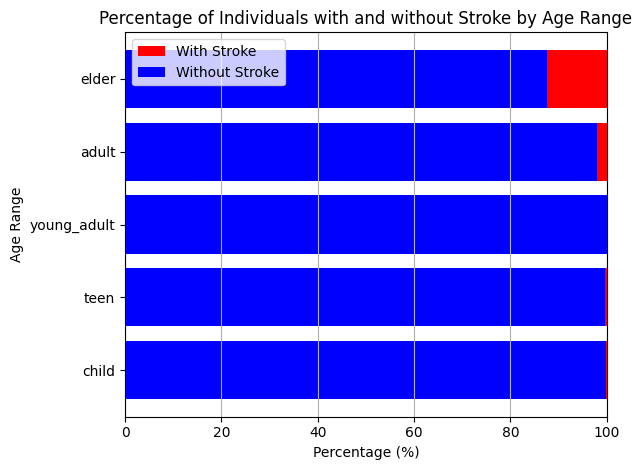

In [19]:
#Plotting the percentage
plt.barh(percent_with_stroke.index, percent_with_stroke, color='red', label='With Stroke', left=100-percent_with_stroke)
plt.barh(percent_no_stroke.index, percent_no_stroke, color='blue', label='Without Stroke')
plt.title('Percentage of Individuals with and without Stroke by Age Range')
plt.xlabel('Percentage (%)')
plt.ylabel('Age Range')
plt.legend()
plt.grid(axis='x')
plt.xlim(0, 100)  # Set x-axis limit from 0 to 100
plt.tight_layout()
plt.show()

It appears that the elders category (>55) have the highest percentage of stroke (12.38%). A reminder that this is not as significant since we have unbalanced data, but it is a well known risk factor for the probability of having a stroke. 

<Axes: xlabel='smoking_status', ylabel='age'>

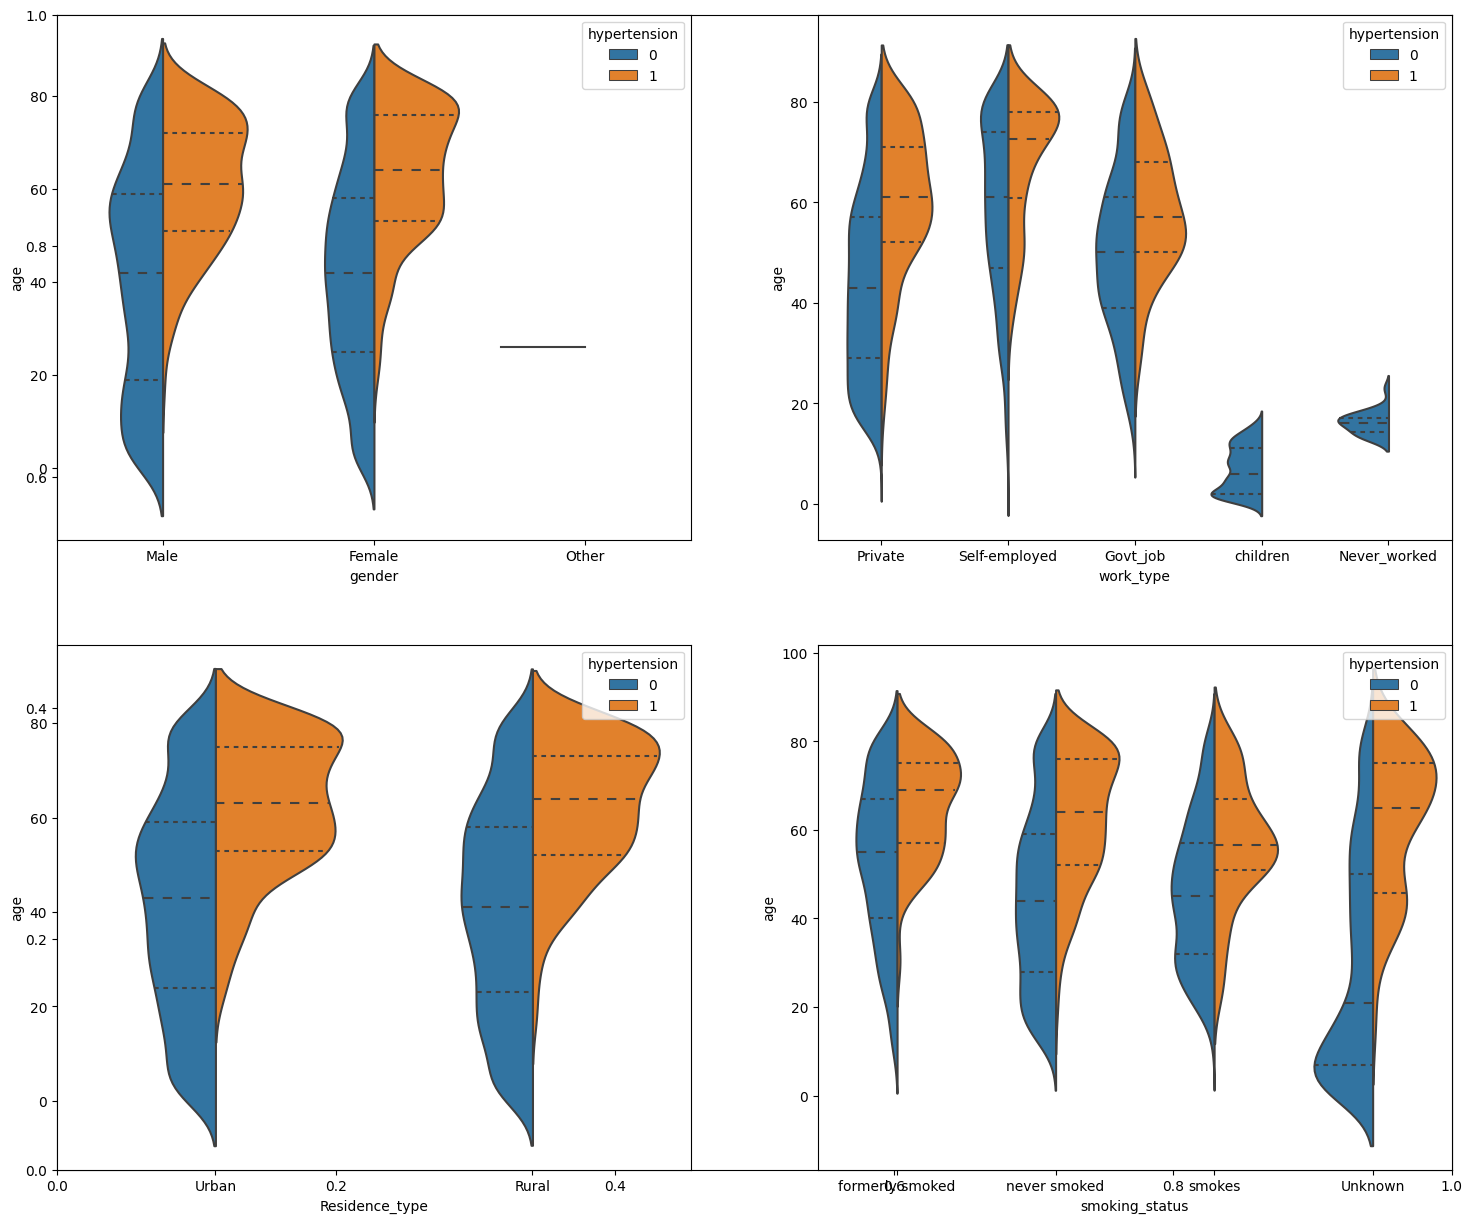

In [20]:
plt.subplots(figsize=(18,15))

plt.subplot(2,2,1)
sns.violinplot(x='gender', y='age', hue='hypertension', data=df, split=True, inner='quart')
plt.subplot(2,2,2)
sns.violinplot(x='work_type', y='age', hue='hypertension', data=df, split=True, inner='quart')
plt.subplot(2,2,3)
sns.violinplot(x='Residence_type', y='age', hue='hypertension', data=df, split=True, inner='quart')
plt.subplot(2,2,4)
sns.violinplot(x='smoking_status', y='age', hue='hypertension', data=df, split=True, inner='quart')

Here we have plotted the continous data age on the y-axis, and categorical features on the x-axis, with the hue representing hypertension. What we can gain from this plot is the distribution of people who have hypertension seems to be effected by certain catergories. For sex, it seems that there is no effect, as both of the distributions for male and female are similiarly distributed in a bimodal fashion. When looking at work type, we see that the self-employed people have hypertension later on in life, with the median being in the mid 70s. Residence type has not apparent effect on hypertension, with both having similiar distribution in age. Lastly, for smoking status, it shows that people who smoke appears to have hypertension at a lower age (with the median below 60, whereas the median for formley smoked and never smoked are above 60). 

[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'avg_glucose_level'),
 Text(2.5, 0, 'stroke'),
 Text(3.5, 0, 'bmi'),
 Text(4.5, 0, 'hypertension'),
 Text(5.5, 0, 'heart_disease')]

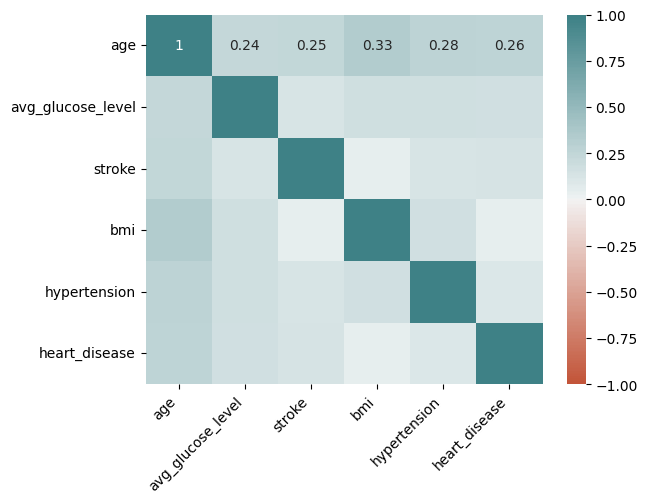

In [24]:
#correlation matrix
variables = ['age', 'avg_glucose_level', 'stroke', 'bmi', 'hypertension', 'heart_disease']

corr = df[variables].corr()
color = sns.diverging_palette(20, 200, n=200) # color palatte inspired by https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec#:~:text=Let's%20start%20by%20making%20a,the%20larger%20the%20correlation%20magnitude.

ax = sns.heatmap(
    corr, 
    cmap=color,
    vmin=-1, vmax=1, center=0,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)


As evident by the correlation matrix, all of the variables of interest are weakly postively correlated (less than 50% positive correlation) with each other. Bmi is the weakest correlation with stroke, whereas age is the highest corelated (albeit weakly), and avg_glucose_level, hypertension, and heart_disease are similarly weakly correlated. The highest positive correlation is age and bmi (0.33), which generally means that the older a person gets, the higher their bmi gets.  

In [25]:
df = pd.read_csv("data/healthcare-dataset-stroke-data.csv")

# preprocess
print(df.shape)
df = df.dropna()
print(df.shape)
labels = df['stroke']
data = df.drop(['stroke'], axis=1)

(5110, 12)
(4909, 12)


In [26]:
# encoded categorical data
data_encoded = pd.get_dummies(data, columns=["gender","ever_married", "work_type", "Residence_type", "smoking_status"])

# scale
data_scaled = StandardScaler().fit_transform(data_encoded)

### 3.2 Questions relavant to the dataset
#### 3.2.1 How many principal componets can roughtly represent the features?

((4909, 22),
 (4909, 15),
 array([0.18443746, 0.0947666 , 0.09130804, 0.07759588, 0.06449584,
        0.05648597, 0.05267047, 0.04995803, 0.04808818, 0.04554202,
        0.04488376, 0.04315487, 0.04151605, 0.0369141 , 0.03348368]),
 0.9653009384706528)

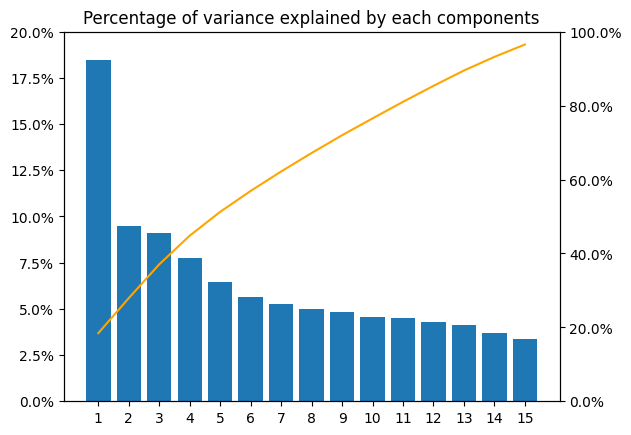

In [27]:
n_components = 15
pca = PCA(n_components)
data_pca = pca.fit_transform(data_scaled)

accumulated_ratio = [pca.explained_variance_ratio_[0]]
for r in pca.explained_variance_ratio_[1:]:
    accumulated_ratio.append(accumulated_ratio[-1] + r)

# ploting
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
plt.xticks(range(1, n_components+1))
plt.yticks(np.arange(0, 0.21, 0.025), [f"{x*100:.1f}%" for x in np.arange(0, 0.21, 0.025)])

ax = plt.twinx()
ax.set_yticks(np.arange(0, 1.01, 0.2), [f"{x*100:.1f}%" for x in np.arange(0, 1.01, 0.2)])
ax.set_ylim(0,1)
ax.plot(range(1, n_components+1), accumulated_ratio, color='orange')

plt.title("Percentage of variance explained by each components")
data_scaled.shape, data_pca.shape, pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)

According to the figure above, first 13 components explained over 90% of variance. Meanwhile, the first component takes up the most of variance, appoximately 20%.

#### 3.2.2. Is the data inherently separable after applying demension deduction?

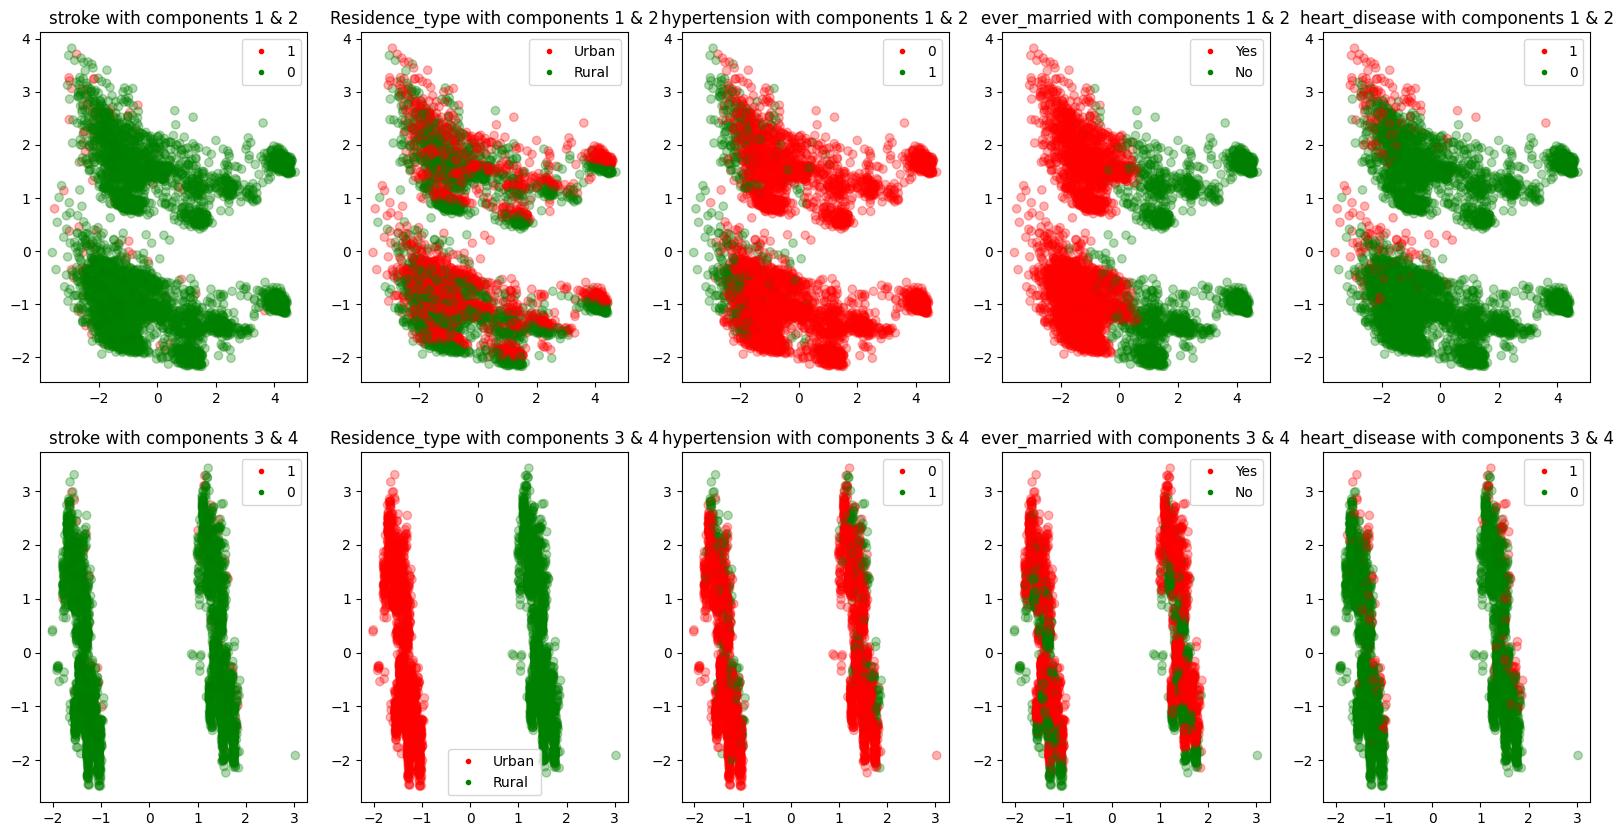

In [28]:
custom_handles = [Line2D([], [], marker='.', color='red', linestyle='None'),
                  Line2D([], [], marker='.', color='green', linestyle='None')]

fig = plt.figure(figsize=(20, 10))
cols = ['stroke','Residence_type', 'hypertension', 'ever_married', 'heart_disease']
index = 0
for i_components in[(0,1), (2,3)]:
    for col in cols:
        index += 1
        
        if col == 'stroke':
            unique_types = list(labels.unique())
            plot_colors = labels.map(lambda x: 'red' if x == unique_types[0] else 'green')
        else:
            unique_types = list(data[col].unique())
            plot_colors = data[col].map(lambda x: 'red' if x == unique_types[0] else 'green')
        ax1 = fig.add_subplot(2, len(cols), index)
        ax1.scatter(
            data_pca[:, i_components[0]],
            data_pca[:, i_components[1]],
            c=plot_colors, alpha=0.3)


        ax1.legend(handles = custom_handles, labels= unique_types)
        plt.title(f"{col} with components {i_components[0]+1} & {i_components[1]+1}", fontsize = 12)


As the figures shown above, the data is separable on some fields. Using the 3rd and 4th principal components, the data is clearly separated in terms of urban or rural residence. With the first and second component, the data can be seprated with hypertension and ever_married status. In other cases, the data points are entangled together. There is no clearly boundary between two classes.

#### 3.2.3 How the classification results differ with and without PCA?

Text(0.5, 1.0, 'Train and Test Time')

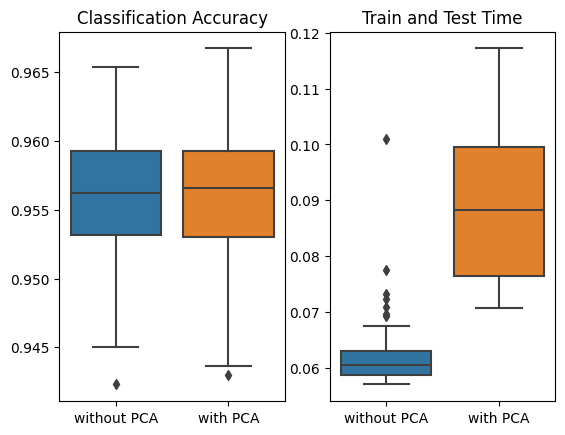

In [31]:
acc_without_pcas, acc_pcas = [], []
time_without_pcas, time_pcas = [], []
for _ in range(100):
    # prepare the data without PCA
    X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, train_size=0.7)
    
    knn = KNeighborsClassifier()
    s_t = time.time()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    time_without_pcas.append(time.time() - s_t)
    cm = confusion_matrix(y_test, y_pred)
    acc_without_pcas.append(np.sum(np.diag(cm))/ np.sum(cm))

    # prepare the data with PCA
    X_train, X_test, y_train, y_test = train_test_split(data_pca, labels, train_size=0.7)

    knn = KNeighborsClassifier()
    s_t = time.time()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    time_pcas.append(time.time() - s_t)
    cm = confusion_matrix(y_test, y_pred)
    acc_pcas.append(np.sum(np.diag(cm))/ np.sum(cm))

ax = plt.subplot(121)
sns.boxplot(data = [acc_without_pcas, acc_pcas])
plt.xticks([0,1], ['without PCA','with PCA'])
plt.title("Classification Accuracy")
ax = plt.subplot(122)
sns.boxplot([time_without_pcas, time_pcas])
plt.xticks([0,1], ['without PCA','with PCA'])
plt.title("Train and Test Time")

As the illustration shown above, the average classification accuracies are basically same. However, classification without PCA leads to a more stable result. Due to the small size of the dataset, the training and testing time is counterintuitive. On this dataset, more time is spent on data after applying PCA.

### 4. Exceptional Work
#### 4.1 Overall Quality
The report is coherent, useful. and polished product. It make sense overall. The visualizations answered the questions in the Business Understanding. The sources are properly cited in the Reference section. Specific reasons for the assumptions are provided. Subsequent questions are followed naturally from initial exploration.
#### 4.2 Additional analysis

UMAP is one of dimension deduction methods. Compare to other techniques such as t-SNE, UMAP offers a number of advantages. Firstly, it's fast. On MINST dataset, UMAP can project the data less than 3 minutes, while t-SNE can take up to 45 minutes. Secondly, UMAP better preserve global structure of the data. This due to UMAP's strong theoretical foundations. Lastly, UMAP offers more understandable parameters that make it a more effective tool for visualizing high dimensional data.

UMAP starts by constructing a graph that captures relationships between data points. It then optimizes a low-dimensional representation that preserves these relationships, ensuring that nearby points in the high-dimensional space remain close in the reduced space. UMAP strikes a balance between preserving local structure, representing fine details, and maintaining global structure, capturing broader patterns.

Text(0.5, 0.92, 'Supervised UMAP Projection of the Stroke Data')

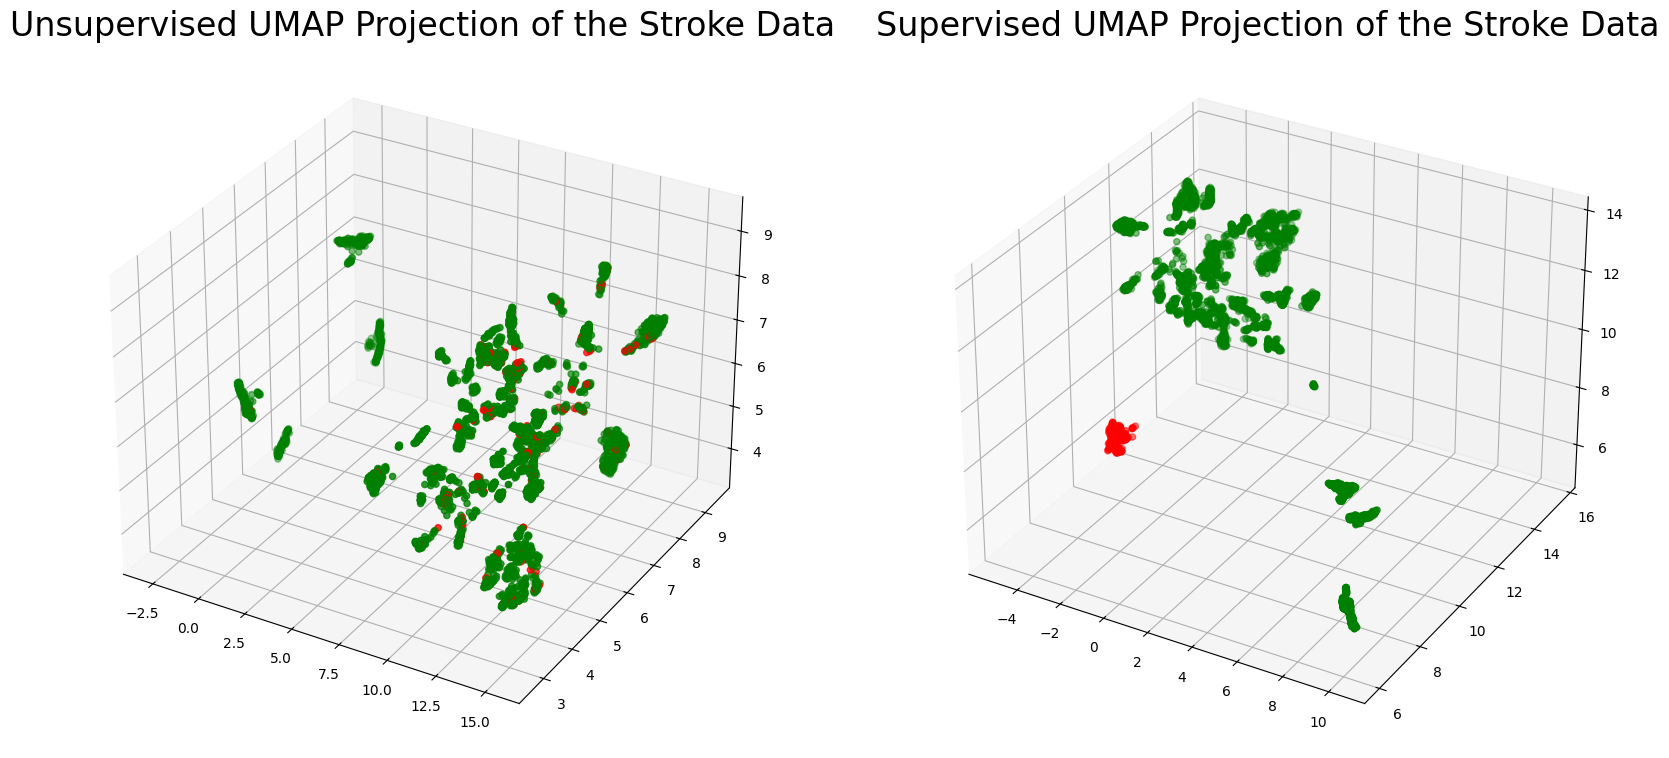

In [32]:
# UMAP dimension deduction
data_umap_unsupervised = umap.UMAP(n_components=3, n_neighbors=500).fit_transform(data_scaled)
data_umap_supervised = umap.UMAP(n_components=3, n_neighbors=500).fit_transform(data_scaled,  y = labels)

# plot the results
plot_colors = labels.map(lambda x: 'red' if x == 1 else 'green')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(
    data_umap_unsupervised[:, 0],
    data_umap_unsupervised[:, 1],
    data_umap_unsupervised[:, 2],
    c=plot_colors)
plt.title('Unsupervised UMAP Projection of the Stroke Data', fontsize=24)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(
    data_umap_supervised[:, 0],
    data_umap_supervised[:, 1],
    data_umap_supervised[:, 2],
    c=plot_colors)
plt.title('Supervised UMAP Projection of the Stroke Data', fontsize=24)

From the plots shown, the unsupervised UMAP failed to separate the dataset. In contrast, the supervised UMAP is able to separate the data into distinct clusters with data labels, despite that a small portion of stroke data is mixed with other data points.

References:

- Kaggle. Stroke Prediction Dataset. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download (Accessed 2-04-2024)

- Center for Disease Control and Prevention. Stroke Facts. https://www.cdc.gov/stroke/facts.htm (Accessed 02-05-2024)

- Stroke Awareness Foundation. Stroke Risk Factors. https://www.strokeinfo.org/stroke-risk-factors/ (Accessed 02-05-2024)

- M.S. Pathan, et. al. "Identifying Stroke Indicators Using Rough Sets". https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9264165 (Accessed 02-05-2024)

- E.M. Alanazi, et. al. "Predicting Risk of Stroke From Lab Tests Using Machine Learning Algorithms: Development and Evaluation of Prediction Models" https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/ (Accessed 02-05-2024)

- D. Zaric. Better Heatmaps and Correlation Matrix Plots in Python. https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec#:~:text=Let's%20start%20by%20making%20a,the%20larger%20the%20correlation%20magnitude. (Accessed 02-07-2024) 



